### Basic Codes

In [1]:
import pandas as pd
import numpy as np
import os
from sklearn.preprocessing import LabelEncoder, StandardScaler
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from imblearn.over_sampling import SMOTE

def load_and_preprocess_mfcc(classCSVPath, label_encoder=None):
    """Loads and preprocesses MFCC data, optionally using an existing label_encoder."""
    mfcc_df = pd.read_csv(classCSVPath)

    if label_encoder is None:
        label_encoder = LabelEncoder()
        label_encoder.fit(mfcc_df["Label"]) #Fit the encoder with all the unique labels.
        mfcc_df["Label"] = label_encoder.transform(mfcc_df["Label"])
    else:
        # Check for new classes and update the encoder if necessary
        new_classes = set(mfcc_df["Label"].unique()) - set(label_encoder.classes_)
        for new_class in new_classes:
            label_encoder.classes_ = np.append(label_encoder.classes_, new_class)
        mfcc_df["Label"] = label_encoder.transform(mfcc_df["Label"])

    mfcc_features = mfcc_df.iloc[:, 3:].values
    labels = mfcc_df["Label"].values

    scaler = StandardScaler()
    mfcc_features = scaler.fit_transform(mfcc_features)
    mfcc_features = mfcc_features.reshape(mfcc_features.shape[0], mfcc_features.shape[1], 1)

    labels_one_hot = to_categorical(labels, num_classes=len(label_encoder.classes_))

    return mfcc_features, labels_one_hot, label_encoder


def load_and_preprocess_spectrogram(spectrogram_paths, label_encoder):
    """Loads and preprocesses spectrogram data."""

    def _load_spectrogram_image(path):  # Inner helper function
        BASE_DIR = os.path.abspath(os.path.join(os.getcwd(), "../"))
        corrected_path = os.path.abspath(os.path.join(BASE_DIR, path))
        if os.path.exists(corrected_path):
            img = load_img(corrected_path, target_size=(224, 224), color_mode='rgb')
            img = img_to_array(img) / 255.0
            return img, os.path.basename(os.path.dirname(corrected_path))
        else:
            print(f"Warning: Spectrogram not found at {corrected_path}")
            return None, None  # Or raise an exception if you prefer

    images = []
    labels = []
    for path in spectrogram_paths:
        img, label = _load_spectrogram_image(path)
        if img is not None:  # Check if image was loaded successfully
            images.append(img)
            labels.append(label)

    images = np.array(images)
    labels = label_encoder.transform(labels) # Use the same LabelEncoder
    labels_one_hot = to_categorical(labels, num_classes=len(label_encoder.classes_))
    return images, labels_one_hot

def apply_augmentation_and_smote(X_train_spectrogram, y_train_spectrogram, label_encoder):
    """Applies data augmentation and SMOTE to spectrogram data."""
    datagen = ImageDataGenerator(
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest'
    )
    datagen.fit(X_train_spectrogram)  # Fit BEFORE SMOTE

    unique_classes = np.unique(np.argmax(y_train_spectrogram, axis=1))
    if len(unique_classes) > 1:  # Apply SMOTE only if multiple classes exist
        smote = SMOTE(random_state=37)
        X_train_reshaped = X_train_spectrogram.reshape(X_train_spectrogram.shape[0], -1)  # Reshape for SMOTE
        X_train_resampled, y_train_resampled = smote.fit_resample(X_train_reshaped, np.argmax(y_train_spectrogram, axis=1))
        X_train_resampled = X_train_resampled.reshape(-1, 224, 224, 3)  # Reshape back
        y_train_resampled = to_categorical(y_train_resampled, num_classes=len(label_encoder.classes_))
    else:
        print("Skipping SMOTE: Only one class detected in y_train_spectrogram.")
        X_train_resampled, y_train_resampled = X_train_spectrogram, y_train_spectrogram  # Use original data

    return X_train_resampled, y_train_resampled, datagen


def apply_smote_mfcc(X_train_mfcc, y_train_mfcc, label_encoder):
    """Applies SMOTE to MFCC data."""
    unique_classes = np.unique(np.argmax(y_train_mfcc, axis=1))
    if len(unique_classes) > 1:  # Apply SMOTE only if multiple classes exist
        smote = SMOTE(random_state=37)
        X_train_reshaped = X_train_mfcc.reshape(X_train_mfcc.shape[0], -1)  # Reshape for SMOTE
        X_train_resampled, y_train_resampled = smote.fit_resample(X_train_reshaped, np.argmax(y_train_mfcc, axis=1))
        X_train_resampled = X_train_resampled.reshape(X_train_resampled.shape[0], X_train_resampled.shape[1], 1)
        y_train_resampled = to_categorical(y_train_resampled, num_classes=len(label_encoder.classes_))
    else:
        print("Skipping SMOTE: Only one class detected in y_train_mfcc.")
        X_train_resampled, y_train_resampled = X_train_mfcc, y_train_mfcc  # Use original data

    return X_train_resampled, y_train_resampled


def SplitDataset(classCSVPath, label_encoder=None):
    """Main function to split and preprocess the dataset."""

    mfcc_features, y_mfcc, label_encoder = load_and_preprocess_mfcc(classCSVPath, label_encoder)
    spectrogram_paths = pd.read_csv(classCSVPath)["Spectrogram_Path"].values

    X_train_mfcc, X_test_mfcc, y_train_mfcc, y_test_mfcc, train_indices, test_indices = train_test_split(
        mfcc_features, y_mfcc, range(len(y_mfcc)), test_size=0.3, random_state=37, stratify = np.argmax(y_mfcc, axis=1) # Stratify based on original labels
    )

    X_train_spectrogram_paths = spectrogram_paths[train_indices]
    X_test_spectrogram_paths = spectrogram_paths[test_indices]

    X_train_spectrogram, y_train_spectrogram = load_and_preprocess_spectrogram(X_train_spectrogram_paths, label_encoder)
    X_test_spectrogram, y_test_spectrogram = load_and_preprocess_spectrogram(X_test_spectrogram_paths, label_encoder)


    X_train_spectrogram_resampled, y_train_spectrogram_resampled, datagen = apply_augmentation_and_smote(X_train_spectrogram, y_train_spectrogram, label_encoder)
    X_train_mfcc_resampled, y_train_mfcc_resampled = apply_smote_mfcc(X_train_mfcc, y_train_mfcc, label_encoder)

    return X_train_mfcc_resampled, y_train_mfcc_resampled, X_test_mfcc, y_test_mfcc, \
           X_train_spectrogram_resampled, y_train_spectrogram_resampled, X_test_spectrogram, y_test_spectrogram, \
           label_encoder, datagen


### MobileNet

In [4]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers, losses, regularizers
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import seaborn as sns
import inspect

class IncrementalMobileNet:
    def __init__(self, input_shape, num_classes, learning_rate=0.0002, l2_reg=0.001): # Added l2_reg parameter
        self.input_shape = input_shape
        self.num_classes = num_classes
        self.learning_rate = learning_rate
        self.l2_reg = l2_reg # Store the L2 regularization value
        self.model = self.build_model()
        self.fisher_matrix = None
        self.previous_weights = None
    


    def build_model(self):
        base_model = MobileNetV2(input_shape=self.input_shape, include_top=False, weights='imagenet')
        base_model.trainable = False  # Freeze the pre-trained layers

        x = layers.GlobalAveragePooling2D()(base_model.output)
        x = layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(self.l2_reg))(x)
        output_layer = layers.Dense(self.num_classes, activation='softmax')(x)

        model = models.Model(inputs=base_model.input, outputs=output_layer)
        model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=self.learning_rate),
                      loss='categorical_crossentropy',
                      metrics=['accuracy'])
        return model


    def train_initial(self, X_train, y_train, epochs=10, batch_size=32, validation_split=0.2):
        y_train_one_hot = to_categorical(y_train, num_classes=self.num_classes)
        early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
        history = self.model.fit(X_train, y_train_one_hot, epochs=epochs, batch_size=batch_size,validation_split=validation_split, verbose=1,callbacks=[early_stopping])
        self.calculate_fisher_matrix(X_train, y_train_one_hot)
        self.previous_weights = self.model.get_weights()
        self.plot_training_history(history)
        print(self.fisher_matrix)
    
    def calculate_fisher_matrix(self, X_train, y_train_one_hot):
        fisher_matrices = [np.zeros_like(weight.numpy()) for weight in self.model.trainable_weights]

        for i in range(len(X_train)):
            with tf.GradientTape() as tape:
                predictions = self.model(np.expand_dims(X_train[i], axis=0))
                loss = losses.categorical_crossentropy(np.expand_dims(y_train_one_hot[i], axis=0), predictions)

            gradients = tape.gradient(loss, self.model.trainable_weights)
            for j, grad in enumerate(gradients):
                if grad is not None:  # Ensure grad is not None (e.g., for unused weights)
                    fisher_matrices[j] += np.square(grad.numpy())

        # Normalize Fisher matrix
        fisher_matrices = [fisher / len(X_train) for fisher in fisher_matrices]
        self.fisher_matrix = fisher_matrices


    def train_incremental(self, X_train, y_train, epochs=5, batch_size=32, ewc_lambda=7.0, validation_split=0.2):
        y_train_one_hot = to_categorical(y_train, num_classes=self.num_classes)
        optimizer = optimizers.Adam(learning_rate=self.learning_rate)

        # Split data for validation
        train_size = int(len(X_train) * (1 - validation_split))
        X_train_train, X_val = X_train[:train_size], X_train[train_size:]
        y_train_train, y_val = y_train_one_hot[:train_size], y_train_one_hot[train_size:]

        history = {'loss': [], 'accuracy': [], 'val_loss': [], 'val_accuracy': []}

        for epoch in range(epochs):
            for batch_start in range(0, len(X_train_train), batch_size):
                batch_end = batch_start + batch_size
                batch_X = X_train_train[batch_start:batch_end]
                batch_y = y_train_train[batch_start:batch_end]

                with tf.GradientTape() as tape:
                    predictions = self.model(batch_X, training=True)
                    loss = losses.categorical_crossentropy(batch_y, predictions)

                    # EWC regularization
                    if self.fisher_matrix and self.previous_weights:
                        ewc_loss = 0.0
                        for i, weight in enumerate(self.model.trainable_weights):
                            # Skip output layer weights in EWC calculation
                            if weight.shape != self.previous_weights[i].shape:
                                continue
                            ewc_loss += ewc_lambda * tf.reduce_sum(self.fisher_matrix[i] * tf.square(weight - self.previous_weights[i]))
                        loss += ewc_loss

                gradients = tape.gradient(loss, self.model.trainable_weights)
                optimizer.apply_gradients(zip(gradients, self.model.trainable_weights))

            # Evaluate on training and validation sets
            train_loss, train_acc = self.model.evaluate(X_train_train, y_train_train, verbose=0)
            val_loss, val_acc = self.model.evaluate(X_val, y_val, verbose=0)

            history['loss'].append(train_loss)
            history['accuracy'].append(train_acc)
            history['val_loss'].append(val_loss)
            history['val_accuracy'].append(val_acc)

            print(f"Epoch {epoch+1}/{epochs}, Loss: {train_loss:.4f}, Accuracy: {train_acc:.4f}, Val_Loss: {val_loss:.4f}, Val_Accuracy: {val_acc:.4f}")

        self.previous_weights = self.model.get_weights()
        self.calculate_fisher_matrix(X_train, y_train_one_hot)
        self.ewc_plot_training_history(history)
        print("Changed fisher matrix: ", self.fisher_matrix)

    def add_new_label(self, X_train, y_train, X_old=None, y_old=None, epochs=5, batch_size=16, ewc_lambda=5.0):
        """Adds a new label to the model incrementally, updating the output layer."""
        
        print(f"🔵 Adding new label: Current num_classes = {self.num_classes}, Incrementing by 1.")
        self.num_classes += 1  # Increment class count

        # Store existing weights
        old_weights = {layer.name: layer.get_weights() for layer in self.model.layers}
        print("✅ Old Weights Stored Successfully!")

        # Retrieve old output layer weights
        old_output_layer = self.model.layers[-1]
        old_output_weights = old_output_layer.get_weights()
        print(f"✅ Old Output Layer Weights Retrieved\nOld Output Layer Weights Shape: {[w.shape for w in old_output_weights]}")

        # Create a new output layer with one additional neuron
        new_output_layer = layers.Dense(self.num_classes, activation='softmax', 
                                        kernel_regularizer=regularizers.l2(self.l2_reg), 
                                        name='new_output_layer')
        print(f"✅ Created New Output Layer with {self.num_classes} Classes")
        
        # Replace the output layer
        x = self.model.layers[-2].output  # Get the previous layer output
        output_tensor = new_output_layer(x)  # Attach the new output layer
        self.model = models.Model(inputs=self.model.input, outputs=output_tensor)
        print("✅ Model Architecture Updated Successfully!")
        
        # Transfer weights to all layers except the output layer
        for layer in self.model.layers[:-1]:
            if layer.name in old_weights:
                layer.set_weights(old_weights[layer.name])
                print(f"✅ Weights Transferred to Layer: {layer.name}")
        
        # Initialize the new output layer with old weights + random values for the new class
        new_output_weights = []
        for i, old_w in enumerate(old_output_weights):
            print(f"🔍 Processing Old Weight {i}: Shape {old_w.shape}")
            
            if old_w.ndim == 2:  # Weight matrix
                new_w = np.concatenate([old_w, np.random.normal(0, 0.01, (old_w.shape[0], 1))], axis=1)
            elif old_w.ndim == 1:  # Bias vector
                new_w = np.concatenate([old_w, np.zeros((1,))], axis=0)
            else:
                print(f"🚨 Unexpected Shape in Weights: {old_w.shape}")
                return  # Stop execution if an error occurs
            
            print(f"✅ New Weight {i} Shape: {new_w.shape}")
            new_output_weights.append(new_w)
        
        print(f"🔍 Final New Output Weights Shape: {[w.shape for w in new_output_weights]}")
        
        # Set new weights for the output layer
        try:
            new_output_layer.set_weights(new_output_weights)
            print("✅ New Output Layer Weights Set Successfully!")
        except ValueError as e:
            print(f"🚨 Weight Assignment Error: {e}")
            return

        # Recompile model
        self.learning_rate = 0.00035
        self.model.compile(optimizer=optimizers.Adam(learning_rate=self.learning_rate),
                        loss=losses.CategoricalCrossentropy(),
                        metrics=['accuracy'])
        print("✅ Model Compiled Successfully!")
        
        # Adjust new labels
        y_train_adjusted = y_train + (self.num_classes - 1 - np.max(y_train))
        print(f"🔄 Adjusted Labels: min={y_train_adjusted.min()}, max={y_train_adjusted.max()}")

        # Merge old and new data
        if X_old is not None and y_old is not None:
            X_combined = np.concatenate((X_train, X_old), axis=0)
            y_combined = np.concatenate((y_train_adjusted, y_old), axis=0)
            print(f"✅ Combined Data: X shape {X_combined.shape}, y shape {y_combined.shape}")
        else:
            X_combined = X_train
            y_combined = y_train_adjusted
            print(f"✅ Using Only New Data: X shape {X_combined.shape}, y shape {y_combined.shape}")

        # Train the model incrementally
        self.train_incremental(X_combined, y_combined, epochs, batch_size, ewc_lambda)
        print("🚀 Incremental Training Complete!")

    def plot_training_history(self, history):
        if history is None:
            return
        plt.figure(figsize=(12, 4))
        plt.subplot(1, 2, 1)
        plt.plot(history.history['accuracy'], label='Train Accuracy')
        if 'val_accuracy' in history.history:
            plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
        plt.legend()
        plt.title('Accuracy')

        plt.subplot(1, 2, 2)
        plt.plot(history.history['loss'], label='Train Loss')
        if 'val_loss' in history.history:
            plt.plot(history.history['val_loss'], label='Validation Loss')
        plt.legend()
        plt.title('Loss')
        plt.show()

    def evaluate_model(self, X_test, y_test, label_encoder): #updated function to accept label_encoder
        y_pred_probs = self.model.predict(X_test)
        y_pred = np.argmax(y_pred_probs, axis=1)
        print(classification_report(y_test, y_pred, target_names=label_encoder.inverse_transform(np.unique(y_test))))
        print(f"Test Accuracy: {np.mean(y_pred == y_test)}")

        cm = confusion_matrix(y_test, y_pred)
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.inverse_transform(np.unique(y_test)), yticklabels=label_encoder.inverse_transform(np.unique(y_test)))
        plt.xlabel('Predicted')
        plt.ylabel('True')
        plt.title('Confusion Matrix')
        plt.show()

    def ewc_plot_training_history(self, history):
        if history is None:
            return
        plt.figure(figsize=(12, 4))
        plt.subplot(1, 2, 1)
        plt.plot(history['accuracy'], label='Train Accuracy')
        if 'val_accuracy' in history:
            plt.plot(history['val_accuracy'], label='Validation Accuracy')
        plt.legend()
        plt.title('Accuracy')

        plt.subplot(1, 2, 2)
        plt.plot(history['loss'], label='Train Loss')
        if 'val_loss' in history:
            plt.plot(history['val_loss'], label='Validation Loss')
        plt.legend()
        plt.title('Loss')
        plt.show()


In [5]:
import pickle

initial_csv_path  = r"..\Dataset\base_audio_mfcc_features_with_labels.csv"
X_train_mfcc, y_train_mfcc, X_test_mfcc, y_test_mfcc, \
X_train_spectrogram, y_train_spectrogram, X_test_spectrogram, y_test_spectrogram, \
label_encoder, datagen = SplitDataset(initial_csv_path)

(224, 224, 3)
4
Epoch 1/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 17s 1s/step - accuracy: 0.4410 - loss: 1.4205 - val_accuracy: 0.7794 - val_loss: 1.0298
Epoch 2/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 8s 945ms/step - accuracy: 0.8517 - loss: 0.8141 - val_accuracy: 0.9265 - val_loss: 0.7477
Epoch 3/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - accuracy: 0.8953 - loss: 0.6515 - val_accuracy: 0.9265 - val_loss: 0.6034
Epoch 4/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step - accuracy: 0.9486 - loss: 0.4947 - val_accuracy: 0.9706 - val_loss: 0.4995
Epoch 5/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - accuracy: 0.9769 - loss: 0.4113 - val_accuracy: 0.9706 - val_loss: 0.4303
Epoch 6/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step - accuracy: 0.9859 - loss: 0.3709 - val_accuracy: 0.9706 - val_loss: 0.3750
Epoch 7/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 9s 958ms/step - accuracy: 0.9788 - loss: 0.3446 - val_accuracy: 0.9853 - val_loss: 0.3473
Epoch 8/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 8s 912ms/step - accuracy: 0.9865 - loss: 0.3082 - val_accuracy: 0.9706 - val_l

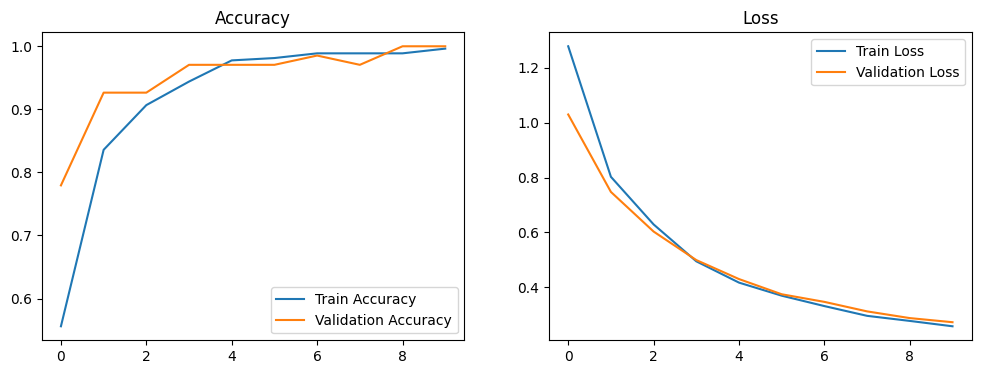

[array([[9.16761928e-05, 0.00000000e+00, 0.00000000e+00, ...,
        2.03384309e-10, 5.86729402e-05, 4.27255218e-05],
       [4.59979565e-05, 0.00000000e+00, 0.00000000e+00, ...,
        7.00355399e-12, 2.98424184e-05, 2.06430723e-05],
       [4.52726454e-05, 0.00000000e+00, 0.00000000e+00, ...,
        3.33129108e-10, 3.64583793e-05, 2.55962987e-05],
       ...,
       [1.81008716e-07, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 3.05190071e-07, 1.23233860e-07],
       [1.52094958e-06, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 9.58027158e-07, 1.16615820e-06],
       [1.16790536e-04, 0.00000000e+00, 0.00000000e+00, ...,
        7.03782935e-11, 8.58432031e-05, 5.46656920e-05]], dtype=float32), array([2.70163669e-04, 0.00000000e+00, 0.00000000e+00, 5.89391057e-05,
       9.73076967e-05, 1.12735943e-04, 1.23969454e-04, 0.00000000e+00,
       0.00000000e+00, 3.98637989e-04, 4.66226993e-05, 2.24816486e-05,
       2.84801470e-04, 0.00000000e+00, 2.29389352

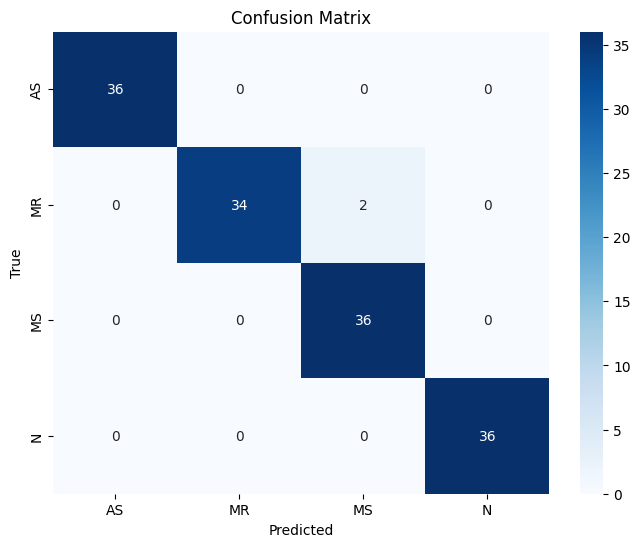

In [6]:
input_shape = (X_train_spectrogram.shape[1], X_train_spectrogram.shape[1],3)  # (time_steps, features)
num_classes = y_train_spectrogram.shape[1]
print(input_shape)
print(num_classes)

model = IncrementalMobileNet(input_shape, num_classes,l2_reg=0.0005)
model.train_initial(X_train_spectrogram, np.argmax(y_train_spectrogram, axis=1))
model.evaluate_model(X_test_spectrogram, np.argmax(y_test_spectrogram, axis=1), label_encoder)

with open("label_encoder.pkl", "wb") as f:
    pickle.dump(label_encoder, f)




Epoch 1/5, Loss: 0.3596, Accuracy: 0.9609, Val_Loss: 0.5483, Val_Accuracy: 0.9111
Epoch 2/5, Loss: 0.3087, Accuracy: 0.9441, Val_Loss: 0.4856, Val_Accuracy: 0.8889
Epoch 3/5, Loss: 0.2736, Accuracy: 0.9832, Val_Loss: 0.3848, Val_Accuracy: 0.9111
Epoch 4/5, Loss: 0.2520, Accuracy: 0.9777, Val_Loss: 0.3622, Val_Accuracy: 0.9333
Epoch 5/5, Loss: 0.2330, Accuracy: 0.9944, Val_Loss: 0.3009, Val_Accuracy: 1.0000


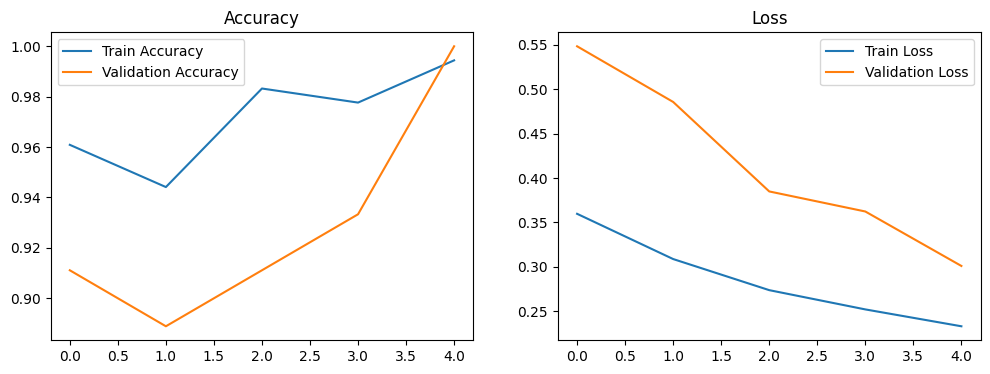

Changed fisher matrix:  [array([[3.8872045e-06, 0.0000000e+00, 0.0000000e+00, ..., 0.0000000e+00,
        2.2070965e-06, 4.2840716e-06],
       [6.2183062e-05, 0.0000000e+00, 0.0000000e+00, ..., 0.0000000e+00,
        9.3623757e-06, 6.7469800e-06],
       [1.4147213e-04, 0.0000000e+00, 0.0000000e+00, ..., 0.0000000e+00,
        2.4387589e-05, 6.2160252e-06],
       ...,
       [5.1870563e-07, 0.0000000e+00, 0.0000000e+00, ..., 0.0000000e+00,
        2.9124007e-07, 6.9960095e-08],
       [1.8037127e-06, 0.0000000e+00, 0.0000000e+00, ..., 0.0000000e+00,
        3.4531783e-07, 1.8497744e-07],
       [1.4910210e-04, 0.0000000e+00, 0.0000000e+00, ..., 0.0000000e+00,
        1.6455528e-05, 3.1982279e-05]], dtype=float32), array([3.72215785e-04, 0.00000000e+00, 0.00000000e+00, 1.39077150e-04,
       3.59785736e-05, 1.98825262e-04, 2.70292454e-04, 0.00000000e+00,
       0.00000000e+00, 7.23643170e-04, 2.47826363e-04, 5.28458077e-05,
       2.46319338e-04, 0.00000000e+00, 3.79560915e-05, 0.0000

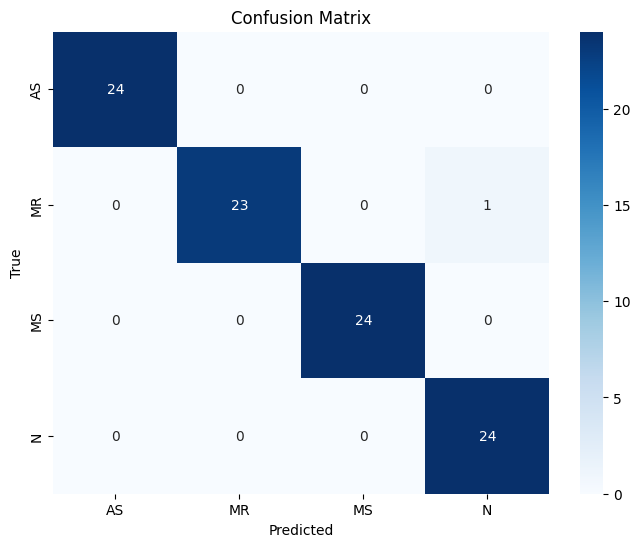

In [7]:
with open("label_encoder.pkl", "rb") as f:
    loaded_label_encoder = pickle.load(f)

incremental_csv_path = r"..\Dataset\inc_audio_mfcc_features_with_labels.csv"

inc_train_x_mfcc, inc_train_y_mfcc, inc_test_x_mfcc, inc_test_y_mfcc, \
inc_train_x_spectrogram, inc_train_y_spectrogram, inc_test_x_spectrogram, inc_test_y_spectrogram, \
upd_label_encoder, datagen = SplitDataset(incremental_csv_path, loaded_label_encoder)

# print(upd_label_encoder.classes_)

model.train_incremental(inc_train_x_spectrogram, np.argmax(inc_train_y_spectrogram, axis=1), validation_split=0.2)
model.evaluate_model(inc_test_x_spectrogram, np.argmax(inc_test_y_spectrogram, axis=1), upd_label_encoder)
with open("label_encoder.pkl", "wb") as f:
    pickle.dump(upd_label_encoder, f)

Skipping SMOTE: Only one class detected in y_train_spectrogram.
Skipping SMOTE: Only one class detected in y_train_mfcc.
[0. 1. 0. 0. 0.]
[0. 1. 0. 0. 0.]
[1. 0. 0. 0. 0.]
Class Mapping in Label Encoder:
AS: 0
MR: 1
MS: 2
N: 3
MVP: 4
🔹 Combined X_train shape: (151, 224, 224, 3)
🔹 Combined y_train shape: (151, 5)
🔵 Adding new label: Current num_classes = 4, Incrementing by 1.
✅ Old Weights Stored Successfully!
✅ Old Output Layer Weights Retrieved
Old Output Layer Weights Shape: [(256, 4), (4,)]
✅ Created New Output Layer with 5 Classes
✅ Model Architecture Updated Successfully!
✅ Weights Transferred to Layer: input_layer
✅ Weights Transferred to Layer: Conv1
✅ Weights Transferred to Layer: bn_Conv1
✅ Weights Transferred to Layer: Conv1_relu
✅ Weights Transferred to Layer: expanded_conv_depthwise
✅ Weights Transferred to Layer: expanded_conv_depthwise_BN
✅ Weights Transferred to Layer: expanded_conv_depthwise_relu
✅ Weights Transferred to Layer: expanded_conv_project
✅ Weights Transferre

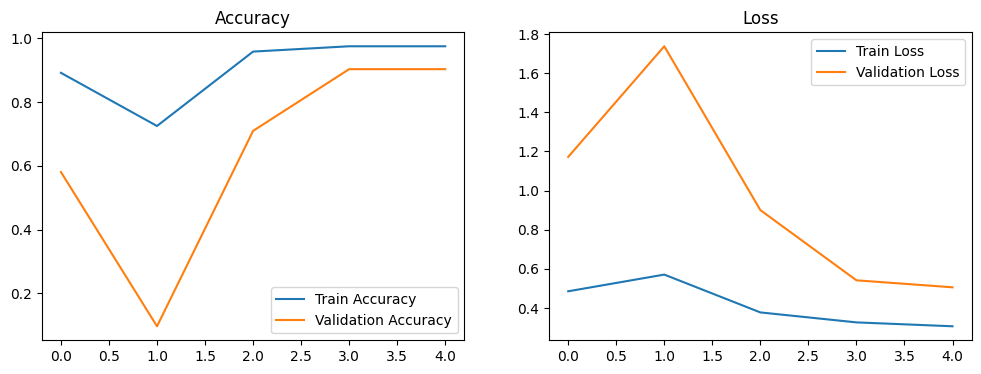

Changed fisher matrix:  [array([[7.9672347e-05, 0.0000000e+00, 0.0000000e+00, ..., 0.0000000e+00,
        1.4941153e-04, 3.2414027e-05],
       [1.0060925e-04, 0.0000000e+00, 0.0000000e+00, ..., 0.0000000e+00,
        1.6489897e-04, 9.5473279e-06],
       [7.4252021e-05, 0.0000000e+00, 0.0000000e+00, ..., 0.0000000e+00,
        1.4460125e-04, 4.9522354e-05],
       ...,
       [2.0269306e-06, 0.0000000e+00, 0.0000000e+00, ..., 0.0000000e+00,
        4.1511998e-06, 4.8234636e-08],
       [2.8025888e-06, 0.0000000e+00, 0.0000000e+00, ..., 0.0000000e+00,
        3.1373543e-06, 4.9358988e-07],
       [2.0034093e-04, 0.0000000e+00, 0.0000000e+00, ..., 0.0000000e+00,
        3.2560591e-04, 7.1716793e-05]], dtype=float32), array([3.01680353e-04, 0.00000000e+00, 0.00000000e+00, 1.50184758e-04,
       2.31471204e-04, 5.21520233e-05, 1.36223462e-04, 0.00000000e+00,
       0.00000000e+00, 1.73010521e-05, 0.00000000e+00, 7.01308716e-04,
       5.06676966e-04, 0.00000000e+00, 5.26459335e-05, 0.0000

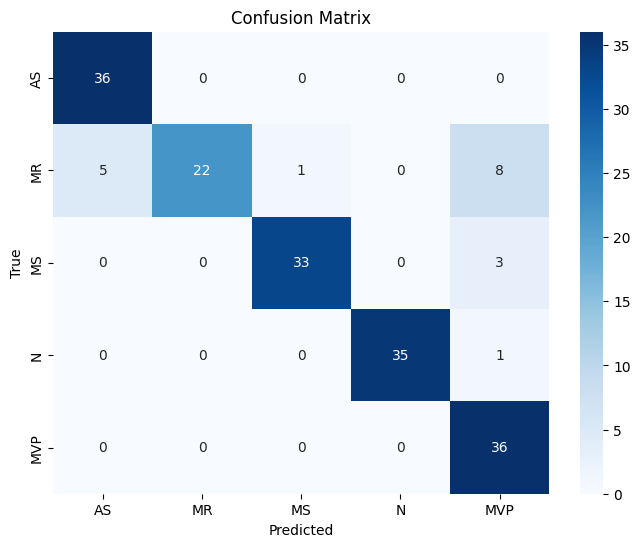

In [8]:

import pickle
import numpy as np

with open("label_encoder.pkl", "rb") as f:
    loaded_label_encoder = pickle.load(f)

mvp_csv_path = r"..\Dataset\continuous_audio_mfcc_features_with_labels.csv"

mvp_train_x_mfcc, mvp_train_y_mfcc, mvp_test_x_mfcc, mvp_test_y_mfcc, \
mvp_train_x_spectrogram, mvp_train_y_spectrogram, mvp_test_x_spectrogram, mvp_test_y_spectrogram, \
upd_label_encoder, _ = SplitDataset(mvp_csv_path, loaded_label_encoder)

# Function to sample data
def sample_data(X, y, sample_ratio=0.3):
    """Randomly selects a percentage of the data."""
    sample_size = int(len(X) * sample_ratio)
    indices = np.random.choice(len(X), sample_size, replace=False)
    return X[indices], y[indices]

old_x_train_mfcc, old_y_train_mfcc, old_x_test_mfcc, old_y_test_mfcc, \
old_x_train_spectrogram, old_y_train_spectrogram, old_x_test_spectrogram, old_y_test_spectrogram, \
upd_label_encoder, _ = SplitDataset(initial_csv_path, upd_label_encoder)

# Sample data from the old dataset
old_x_sample, old_y_sample = sample_data(old_x_train_spectrogram, old_y_train_spectrogram, sample_ratio=0.2)


print(old_y_train_spectrogram[3])
print(old_y_sample[3])
print(old_y_test_spectrogram[12])

print("Class Mapping in Label Encoder:")
for class_name, encoded_value in zip(upd_label_encoder.classes_, range(len(upd_label_encoder.classes_))):
    print(f"{class_name}: {encoded_value}")

combined_x_train = np.concatenate((mvp_train_x_spectrogram, old_x_sample), axis=0)
combined_y_train = np.concatenate((mvp_train_y_spectrogram, old_y_sample), axis=0)

print(f"🔹 Combined X_train shape: {combined_x_train.shape}")
print(f"🔹 Combined y_train shape: {combined_y_train.shape}")

model.add_new_label(combined_x_train, np.argmax(combined_y_train, axis=1))

X_combined_test = np.concatenate((old_x_test_spectrogram, mvp_test_x_spectrogram), axis=0)
y_combined_test = np.concatenate((old_y_test_spectrogram, mvp_test_y_spectrogram), axis=0)

model.evaluate_model(X_combined_test, np.argmax(y_combined_test, axis=1), upd_label_encoder)

with open("label_encoder.pkl", "wb") as f:
    pickle.dump(upd_label_encoder, f)
